In [1]:
import nilmtk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 20 days


In [2]:
from nilmtk import *
import os

In [5]:
st = pd.HDFStore(os.path.expanduser("~/Downloads/wiki-temp.h5"))
o = {}

all_keys = st.keys()
for k in all_keys:
    try:
        o[k] = len(st[k]['2013'])
    except:
        pass

s = pd.Series(o)
homes_keys = s[s>505478].index.tolist()
homes_int = map(lambda x: int(x[1:]),homes_keys)


survey_df = pd.read_csv(os.path.expanduser("~/git/nilm-actionable/data/total/survey_2013.csv"))

common_homes = np.intersect1d(survey_df.dataid.values, homes_int)

common_homes_keys = map(lambda x: "/"+str(x), common_homes)

In [6]:
common_homes

array([  26,   94,  252,  370,  410,  545,  624,  871, 1169, 1283, 1334,
       1642, 1697, 1800, 1953, 2129, 2156, 2233, 2242, 2470, 2814, 2829,
       2925, 2986, 3224, 3367, 3456, 3482, 3723, 3778, 3967, 4031, 4505,
       4732, 4767, 4957, 5218, 5357, 5371, 5439, 5746, 5785, 5814, 5817,
       6072, 6121, 6139, 6266, 6636, 6836, 6910, 7016, 7429, 7510, 7731,
       7741, 7769, 7800, 7850, 7866, 8317, 8626, 9052, 9499, 9609, 9654,
       9729, 9922, 9933, 9934, 9982])

In [220]:
models = {}
for appliance in ["refrigerator1","air1", "dishwasher1","clotheswasher1","drye1"]:
    print appliance
    
    o = []
    for key in common_homes_keys[:20]:
        print key

        df = st[key]['2013']
        df_res = df.resample("15T").fillna(method='ffill')
        if appliance in df_res.columns:
            appl_power = df_res[appliance].head(5000).values
            if np.sum(appl_power)>10000:
                o.append(appl_power)
    o = np.array(o)
    mod = hmm.GaussianHMM(2, "full")
    mod.fit([o.reshape(-1,1)])
    models[appliance] = mod

refrigerator1
/26
/94
/252
/370
/410
/545
/624
/871
/1169
/1283
/1334
/1642
/1697
/1800
/1953
/2129
/2156
/2233
/2242
/2470
air1
/26
/94
/252
/370
/410
/545
/624
/871
/1169
/1283
/1334
/1642
/1697
/1800
/1953
/2129
/2156
/2233
/2242
/2470
dishwasher1
/26
/94
/252
/370
/410
/545
/624
/871
/1169
/1283
/1334
/1642
/1697
/1800
/1953
/2129
/2156
/2233
/2242
/2470
clotheswasher1
/26
/94
/252
/370
/410
/545
/624
/871
/1169
/1283
/1334
/1642
/1697
/1800
/1953
/2129
/2156
/2233
/2242
/2470
drye1
/26
/94
/252
/370
/410
/545
/624
/871
/1169
/1283
/1334
/1642
/1697
/1800
/1953
/2129
/2156
/2233
/2242
/2470


In [221]:
from nilmtk.disaggregate.fhmm_exact import sort_learnt_parameters

In [222]:
new_learnt_models = OrderedDict()
for appliance, appliance_model in models.iteritems():
    startprob, means, covars, transmat = sort_learnt_parameters(
                    appliance_model.startprob_, appliance_model.means_,
                    appliance_model.covars_, appliance_model.transmat_)
    new_learnt_models[appliance] = hmm.GaussianHMM(
                startprob.size, "full", startprob, transmat)
    new_learnt_models[appliance].means_ = means
    new_learnt_models[appliance].covars_ = covars

In [223]:
from nilmtk.disaggregate.fhmm_exact import create_combined_hmm

In [224]:
learnt_model_combined = create_combined_hmm(new_learnt_models)

In [228]:
new_learnt_models['clotheswasher1'].means_

array([[   0.54056336],
       [ 126.11893104]])

In [230]:
df_26 = st[key]['2013'].resample("15T")

In [231]:
mains_26 = df_26["use"]

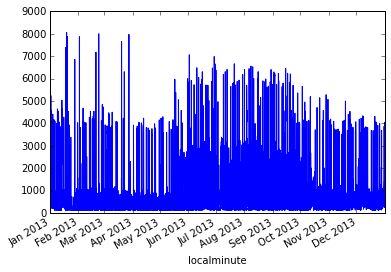

In [233]:
mains_26.plot()

In [234]:
from nilmtk.disaggregate.fhmm_exact import FHMM

In [235]:
f = FHMM()

In [239]:
f.model = learnt_model_combined
f.individual = new_learnt_models

In [257]:
import pickle

In [258]:
pickle.dump(f, open( "../fhmm_model.p", "wb" ))

In [252]:
pred = f.disaggregate_chunk(mains_26)


In [256]:
print (pred['refrigerator1'].sum()-df_26['refrigerator1'].sum())/df_26['refrigerator1'].sum()

-0.207079013041


In [145]:
mod.fit([o[0].reshape(-1,1)])

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1,
      init_params='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',
      means_prior=None, means_weight=0, n_components=2, n_iter=10,
      params='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',
      random_state=None, startprob=None, startprob_prior=1.0, thresh=0.01,
      transmat=None, transmat_prior=1.0)

In [146]:
mod.means_

array([[   0.        ],
       [ 987.96043864]])

In [60]:

startprob = np.array([0.6, 0.3, 0.1, 0.0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.7, 0.2, 0.0, 0.1],
                     [0.3, 0.5, 0.2, 0.0],
                     [0.0, 0.3, 0.5, 0.2],
                     [0.2, 0.0, 0.2, 0.6]])
# The means of each component
means = np.array([[0.0,  0.0],
                  [0.0, 11.0],
                  [9.0, 10.0],
                  [11.0, -1.0]])
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (4, 1, 1))

# Build an HMM instance and set parameters
model = hmm.GaussianHMM(n_components=4, covariance_type="full",
                        random_state=42)

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars
###############################################################

# Generate samples
X, Z = model.sample(500)

In [64]:
model.fit([X])

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1,
      init_params='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',
      means_prior=None, means_weight=0, n_components=4, n_iter=10,
      params='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',
      random_state=42, startprob=None, startprob_prior=1.0, thresh=0.01,
      transmat=None, transmat_prior=1.0)

In [67]:
model.transmat_

array([[  7.32035166e-01,   1.47944834e-01,   1.01478454e-01,
          1.85415463e-02],
       [  1.76165797e-01,   7.25388601e-01,   9.84454431e-02,
          1.58890415e-07],
       [  3.42950776e-02,   2.47572979e-01,   6.16853483e-01,
          1.01278460e-01],
       [  7.03806603e-01,   6.67735612e-08,   2.95388532e-01,
          8.04797824e-04]])

In [24]:
%matplotlib inline

In [26]:
df['refrigerator1']['2013'].resample("15T").head(10000).plot()

KeyError: 'refrigerator1'